In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
from IPython import display

In [27]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(1000),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(1000),
        transforms.Resize(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {
    x: datasets.ImageFolder(
        "data/",
        data_transforms[x]
    ) for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=4,
        shuffle=True,
        num_workers=4
    ) for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
use_gpu = torch.cuda.is_available()

In [12]:
dataset_sizes

{'train': 28, 'val': 28}

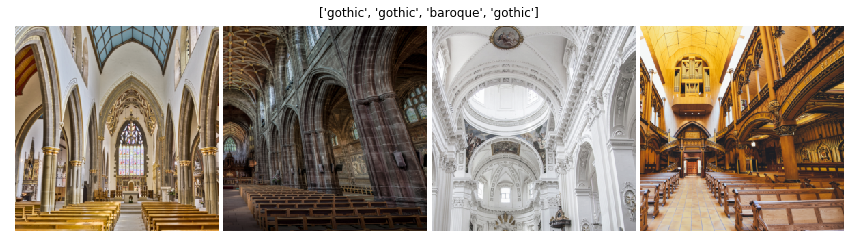

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    plt.xticks(tuple())
    plt.axis("off")
    plt.yticks(tuple())
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs, pad_value=255, padding=6)

imshow(out, title=[class_names[x] for x in classes])

In [29]:
def plot_all_in_once(train_loss_history, val_loss_history, train_acc_history, val_acc_history, show_best=False):
    display.clear_output()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(range(len(train_loss_history)), train_loss_history, label="train")
    ax1.plot(range(len(val_loss_history)), val_loss_history, label="validate")
    ax1.legend()
    ax1.set_title('Loss')
    
    ax2.plot(range(len(train_acc_history)), train_acc_history, label="train")
    ax2.plot(range(len(val_acc_history)), val_acc_history, label="validate")
    if show_best:
        ax2.plot([val_acc_history.index(max(val_acc_history))], [max(val_acc_history)], "r*", label="best accuracy")
    ax2.legend()
    ax2.set_title('Accuracy')

    plt.show()

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)
        current_dataloaders = dataloaders
        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установить модель в режим обучения
            else:
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(current_dataloaders[phase]):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)
                #print(outputs.shape)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #    phase, epoch_loss, epoch_acc))
            
            if phase == "train":
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            elif phase == "val":
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                raise Exception("Impossible phase '%s'" % phase)
            
            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        plot_all_in_once(train_loss_history, val_loss_history, train_acc_history, val_acc_history, show_best=True)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_batches=2):
    model.train(False)
    hardcoded_class_names = {
        309: "bees",
        310: "ants"
    }
    cnt = 0
    test_iter = iter(dataloaders["val"])
    for _ in range(num_batches):
        inputs, labels = next(test_iter)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        out = torchvision.utils.make_grid(inputs.data, pad_value=255, padding=5)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        imshow(
            out, title="                                           ".join(
                map(lambda i: class_names[i] if i < 2 else hardcoded_class_names.get(i, "Unknown: " + str(i)), preds)
            )
        )

## Feature extractor

In [30]:
inception_ = models.inception_v3(pretrained=True)
inception_.aux_logits = False

In [31]:
for param in inception_.parameters():
    param.requires_grad = False

inception_.fc = nn.Linear(2048, 2)
if use_gpu:
    inception_ = inception_.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(inception_.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

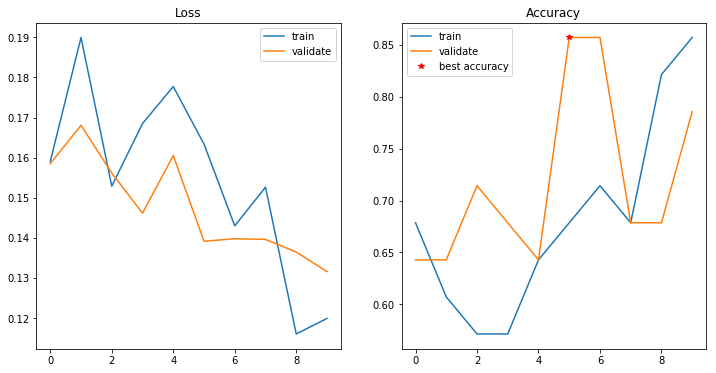

Training complete in 5m 30s
Best val Acc: 0.857143
CPU times: user 5min 42s, sys: 19.9 s, total: 6min 2s
Wall time: 5min 30s


In [32]:
%%time
inception_ = train_model(inception_, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

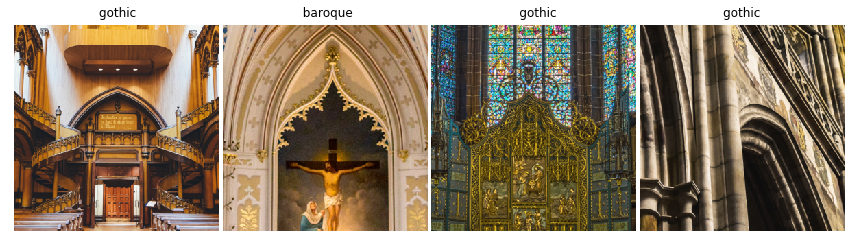

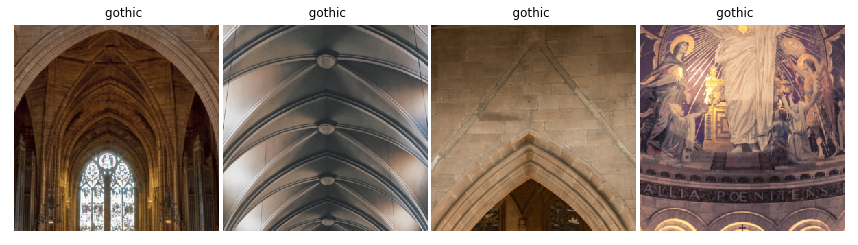

In [35]:
visualize_model(inception_)

Как видно, результаты не слишком впечатляющие.

## Fine tuning

In [36]:
inception_ = models.inception_v3(pretrained=True)
inception_.aux_logits = False

for param, i in zip(inception_.parameters(), range(int(len(tuple(inception_.parameters())) * 0.8))):
    if hasattr(param, "requires_grad"):
        param.requires_grad = False

inception_.fc = nn.Linear(2048, 2)
if use_gpu:
    inception_ = inception_.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD((i for i in inception_.parameters() if i.requires_grad), lr=0.001, momentum=0.2)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

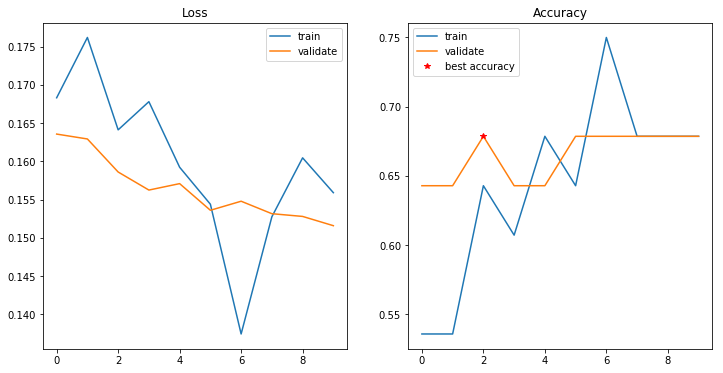

Training complete in 6m 44s
Best val Acc: 0.678571
CPU times: user 6min 46s, sys: 32.3 s, total: 7min 18s
Wall time: 6min 43s


In [37]:
%%time
inception_ = train_model(inception_, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

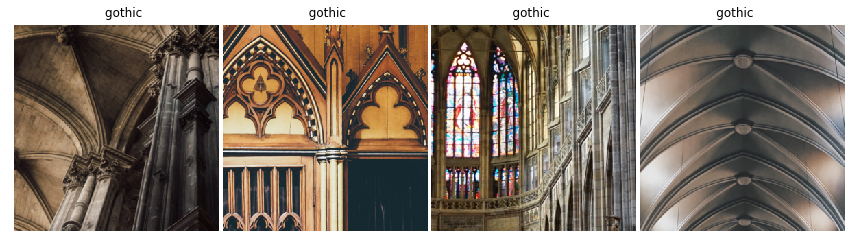

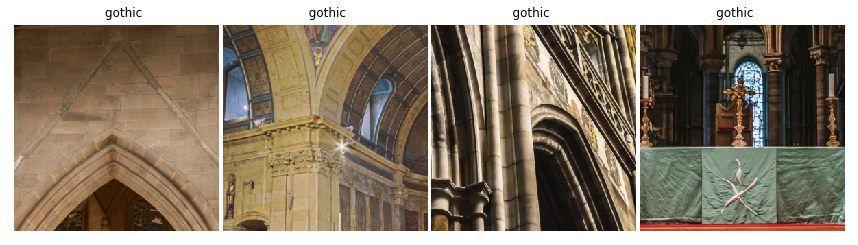

In [39]:
visualize_model(inception_)

## Вывод
Действительно, малое количество данных, не похожих на тренровочные данные -- самый плохой вариант.